In [1]:
import scanpy as sc
import numpy as np
import scanpy.external as sce
import pandas as pd
import scvelo as scv
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import sys
import symphonypy as sp

# Figures aesthetics
sc.set_figure_params(dpi=150)

# Pathes
DATA_PATH = "/home/sergey/data/clonal_project"
HOME_PATH = "/home/sergey/projects/clonal_project"

# Additional functions
exec(open(f"{HOME_PATH}/tools/tools.py").read())
sns.set_style("ticks")

g2m_genes = list(pd.read_csv("/home/sergey/data/additional/cell_cycle_genes/G2M_phase.txt", names=["gene"]).gene)
g2m_genes = [gene[0].upper() + gene[1:].lower() for gene in g2m_genes]

s_genes = list(pd.read_csv("/home/sergey/data/additional/cell_cycle_genes/S_phase.txt", names=["gene"]).gene)
s_genes = [gene[0].upper() + gene[1:].lower() for gene in s_genes]

In [2]:
reference_injections = [
    "injection1",
    "injection2",
    "injection3",
    "injection4",
    "injection5",
    "injection6",
    "injection7",
]

adata = []
for injection in reference_injections:
    adata.append(sc.read_h5ad(f"{DATA_PATH}/anndatas_counts/{injection}.h5ad"))
adata = adata[0].concatenate(adata[1:], join="outer", batch_key=None, fill_value=0, index_unique=None)
adata.obs["E8.5:clones"] = adata.obs["E8.5:clones"].fillna("NA")
adata.obs["E7.5:clones"] = adata.obs["E7.5:clones"].fillna("NA")
adata.var = adata.var[["gene_ids-0", "mt-0"]]
adata.var.columns = ["gene_ids", "mt"]
adata = adata[:, ~np.isin(adata.var_names, ["GFPbc", "TOMbc"])]
adata.layers["counts"] = adata.X.copy()
adata.var.mt = adata.var.mt.astype(bool)

adata.write_h5ad(f"{DATA_PATH}/anndatas_counts/reference_E13.h5ad")

In [2]:
adata = sc.read_h5ad(f"{DATA_PATH}/anndatas_counts/reference_E13.h5ad")

In [3]:
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    batch_key="sample_id",
    flavor="seurat_v3",
    layer="counts",
    n_top_genes=3000,
)
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
adata.raw = adata

In [5]:
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata, n_comps=30)

In [ ]:
sp.pp.harmony_integrate(adata, key="sample_id", max_iter_harmony=30, verbose=True)
sc.pp.neighbors(adata, n_neighbors=20, use_rep="X_pca_harmony")
sc.tl.umap(adata)

Harmony integration with harmonypy is preforming.


2023-02-10 01:59:53,344 - harmonypy - INFO - Iteration 1 of 30
2023-02-10 02:01:44,721 - harmonypy - INFO - Iteration 2 of 30
2023-02-10 02:03:37,551 - harmonypy - INFO - Iteration 3 of 30
2023-02-10 02:05:28,414 - harmonypy - INFO - Iteration 4 of 30


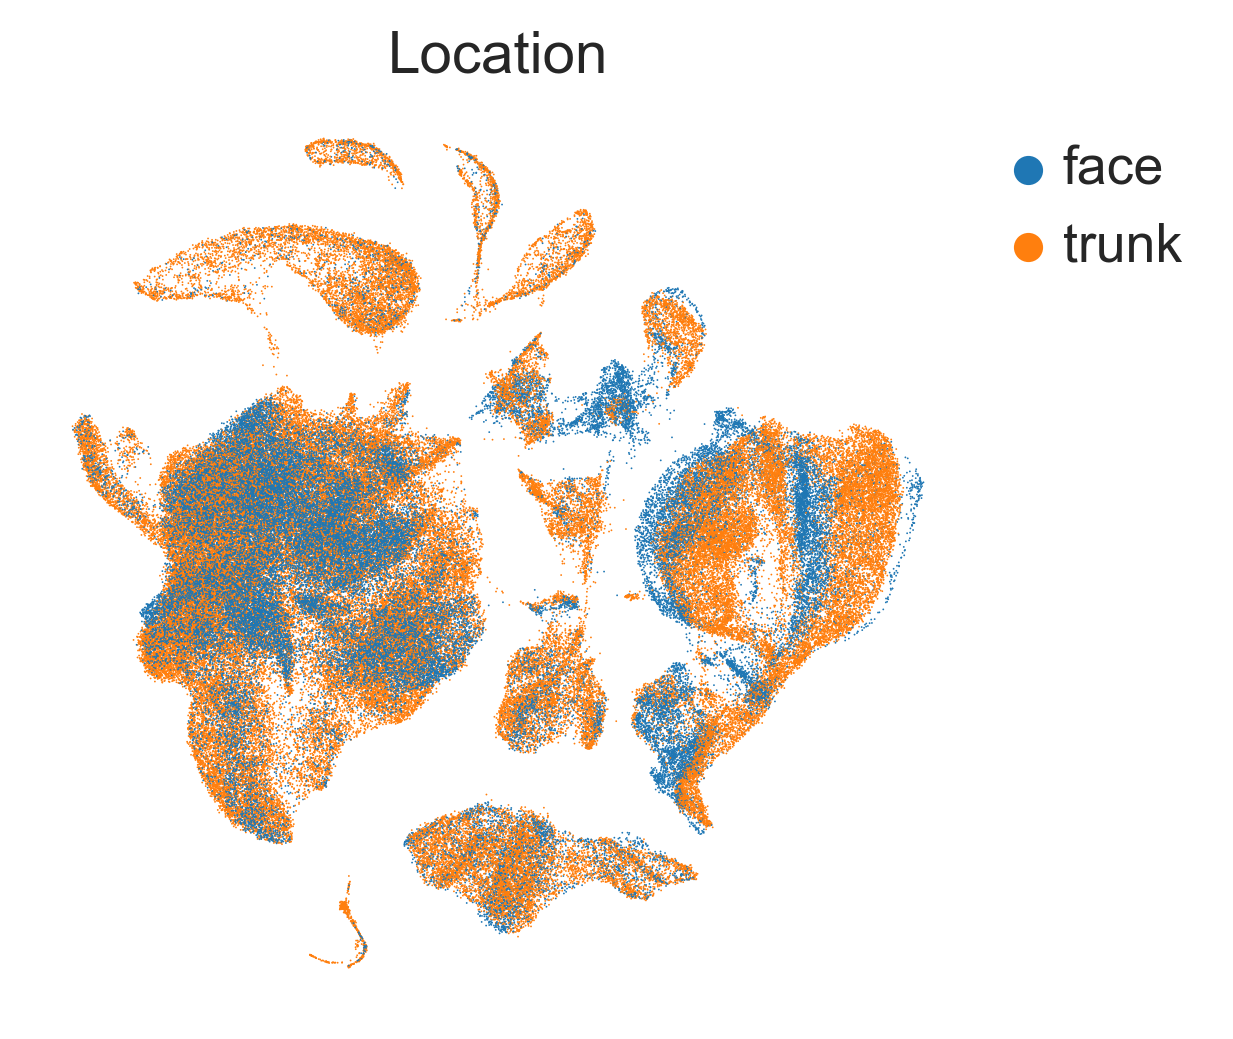

In [11]:
scv.pl.scatter(adata, basis="X_umap", frameon=False, title="Location", color="location")

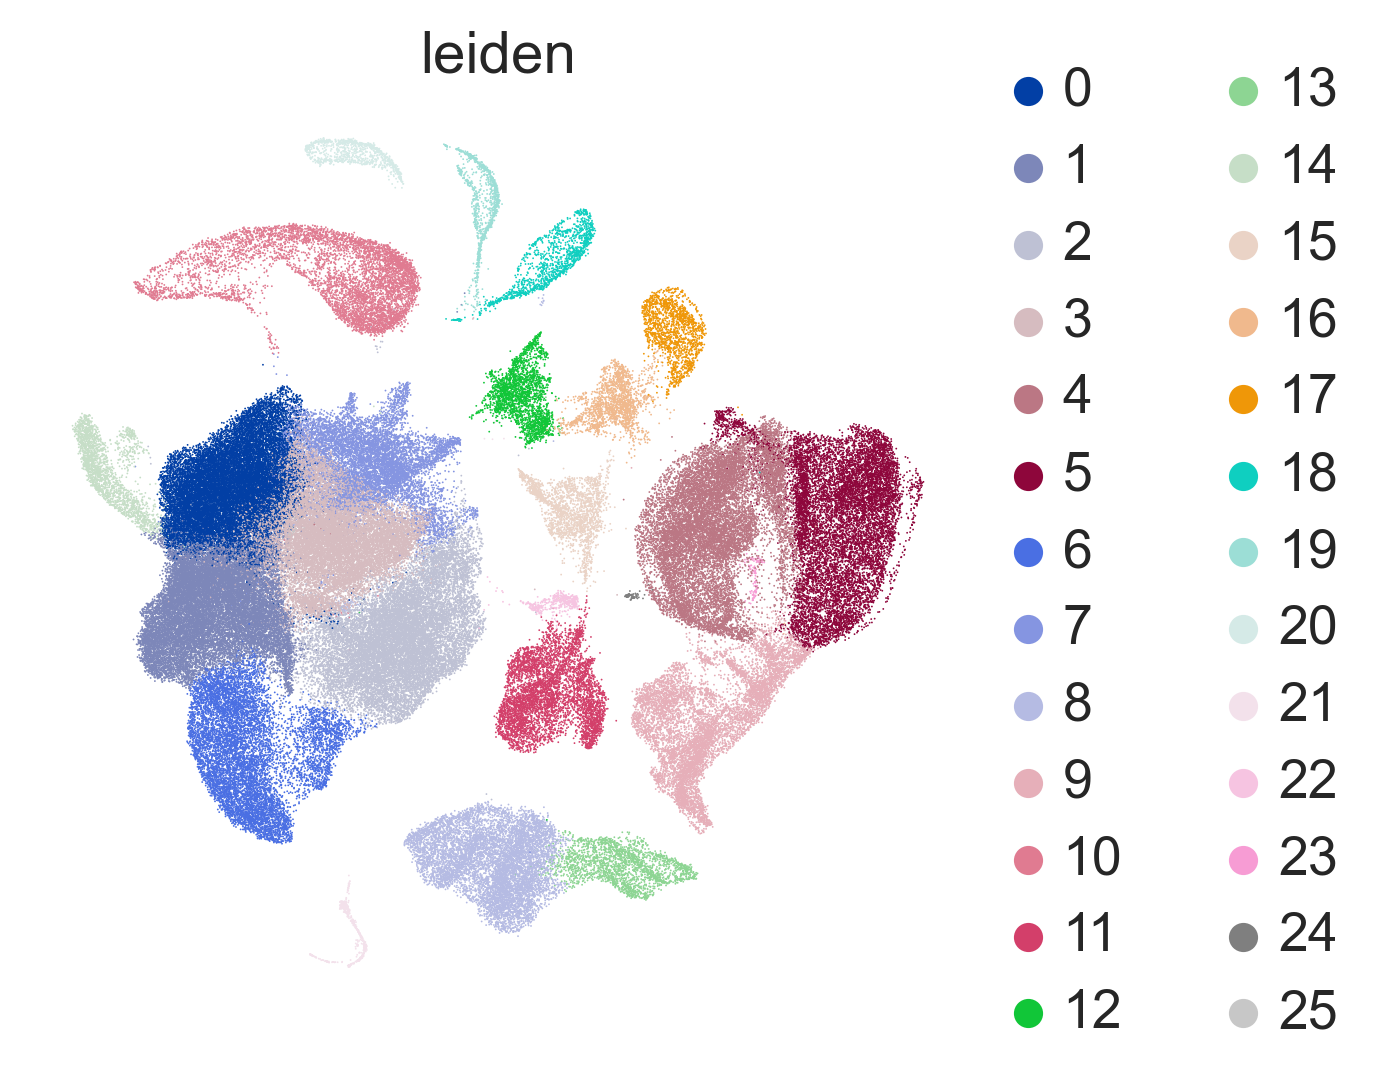

In [12]:
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color="leiden", frameon=False)

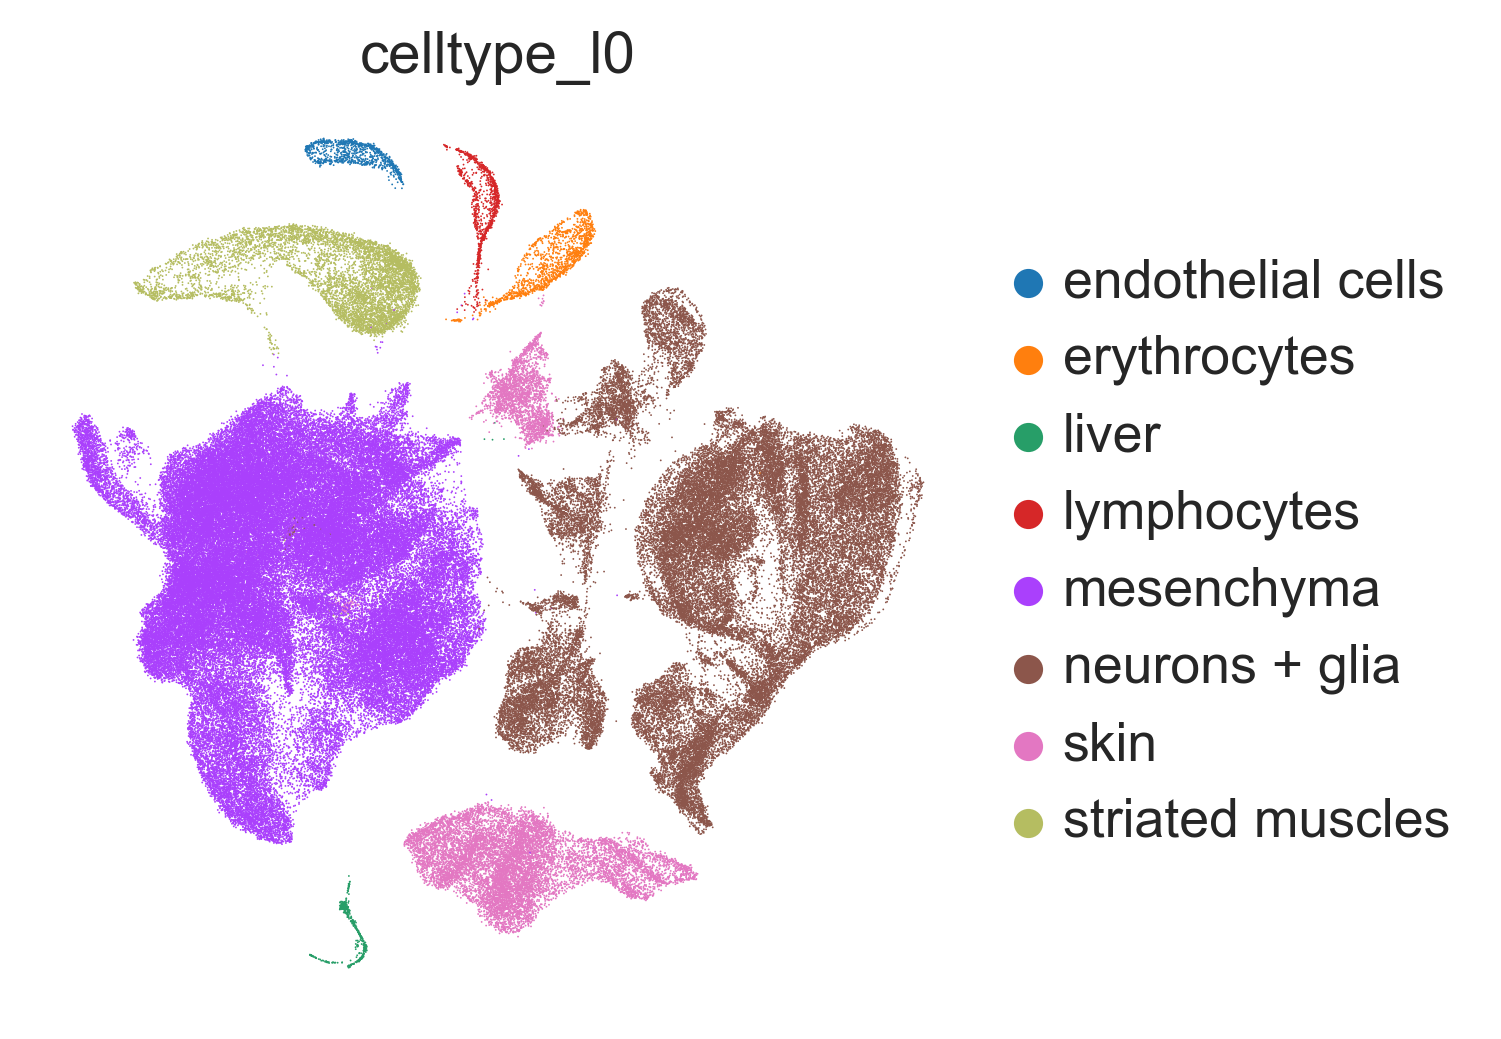

In [62]:
ct_to_leiden = {
    "erythrocytes": ["18"],
    "striated muscles": ["10"],
    "lymphocytes": ["19"],
    "endothelial cells": ["20"],
    "liver": ["21"],
    "skin": ["8", "12", "13"],
    "neurons + glia": [
        "4", "5", "9", "11", "15", "16",
        "17", "22", "23", "24", "25",
    ],
    "mesenchyma": [
        "0", "1", "2", "3", "6", "7", "14"
    ],
}

leiden_to_ct = {}
for ct in ct_to_leiden:
    for leiden in ct_to_leiden[ct]:
        leiden_to_ct[leiden] = ct
        
adata.obs["celltype_l0"] = [leiden_to_ct[leiden] for leiden in adata.obs.leiden]
sc.pl.umap(adata, color="celltype_l0", frameon=False)

In [63]:
adata.write_h5ad(f"{DATA_PATH}/anndatas/reference_integrations_E13.h5ad")